In [11]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from scipy.interpolate import interp1d
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
from scipy.optimize import leastsq
import astropy.constants as const
from astropy.modeling import models, fitting

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

Miscelanous plots

In [2]:
#t1data = Table.read('../combined/trappist-1_sed_var_res_v04.ecsv')
t1data = Table.read('../../common/quicksaves/2MASS-J23062928-0502285_basic.ecsv')
w, f, e = t1data['WAVELENGTH'], t1data['FLUX'], t1data['ERROR']

In [3]:
sol_spec =  readsav('../../../stuff/Solar-data.idlsav')
w_sol, f_sol = sol_spec['wave']*10, sol_spec['flux']*100

Scaled to bolometric flux

1.1800458785565196e+16 k4 pc2 / K4


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/david/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


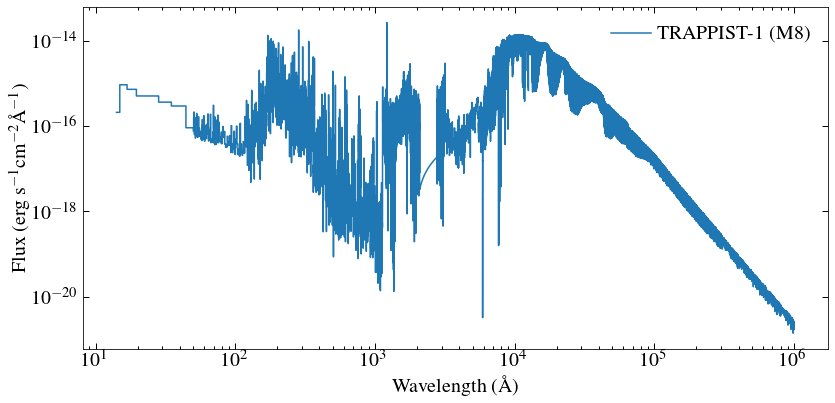

In [4]:
d_t1 = 12.1*u.pc 
d_sun = 1*u.au.to(u.pc)

#### scale by bolometric ps flux
r_t1 = 0.117*u.Rsun
#r_674 = 0.35*u.Rsun
t_t1= 2560*u.K
#t_674 = 3400*u.K
t_sun = 5777*u.k
bb_scale = (u.Rsun**2 * t_sun**4)/(r_t1**2 * t_t1**4)*(d_t1/d_sun)**2
print(bb_scale)

plt.figure(figsize=(12,6))
plt.step(w[f>0], f[f>0],label ='TRAPPIST-1 (M8)', where='mid')
#plt.step(w_sol[w_sol>w[0]], f_sol[w_sol>w[0]]/bb_scale, zorder=-1, label = 'Sun (scaled)' , where='mid')
plt.xscale('log')
plt.yscale('log')
#plt.xlim(100, 1000)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
plt.legend()
plt.tight_layout()
#plt.savefig('../plots/Trappist1_GJ674_bb_scaled.pdf', dpi=150)
#plt.savefig('../plots/Trappist1_GJ674_bb_scaled.png', dpi=150)
#plt.savefig('../plots/Trappist1_solar_euv_scaled.png', dpi=150)


Hmm, very messy - better to do it with sep model? Or smooth the COS bits

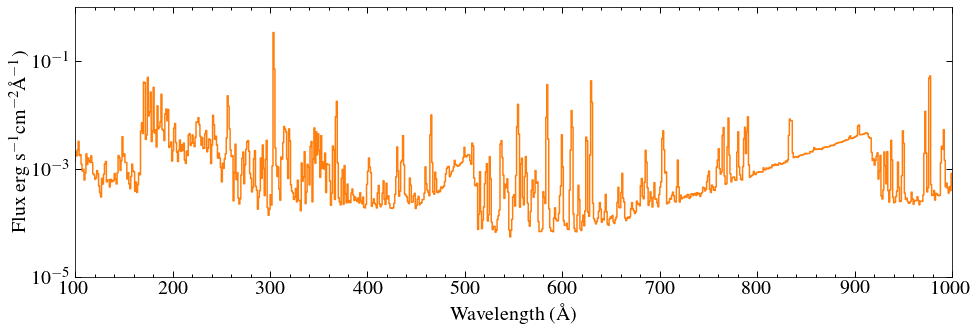

In [5]:
plt.step(w_sol, f_sol, zorder=-1, label = 'Sun (scaled)' , where='mid', c='C1')
plt.xlim(100, 1000)
plt.ylim(1e-5, 1)
plt.yscale('log')
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
plt.tight_layout()
plt.savefig('sun_euv.png', dpi=100)


Data sources plot

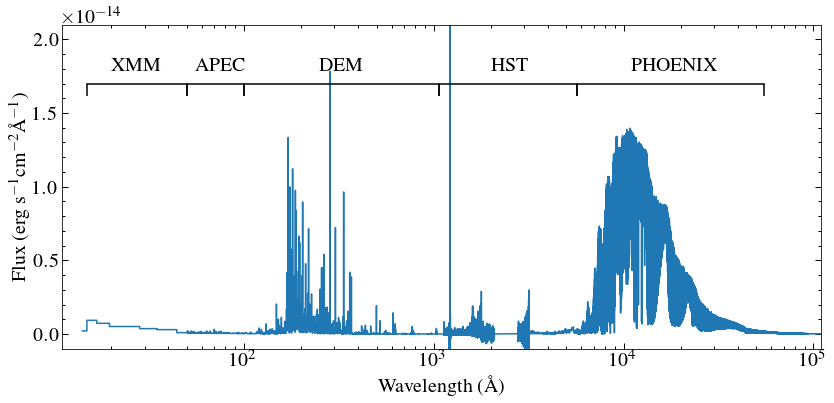

In [6]:

#fig, ax = plt.subplots(figsize=(13,7))
plt.figure(figsize=(12,6))
#ax.set_figsize = (12,7)

labely = 1.7e-14
labelfac = 1.05
plt.errorbar((15,50),(labely, labely), yerr= [[0.05*labely, 0.05*labely],[0,0]], c ='k')
plt.annotate('XMM', (20, labelfac*labely))

plt.errorbar((50,100),(labely, labely), yerr= [[0.05*labely, 0.05*labely],[0,0]], c ='k')
plt.annotate('APEC', (55, labelfac*labely))

plt.errorbar((100,1060),(labely, labely), yerr= [[0.05*labely, 0.05*labely],[0,0]], c ='k')
plt.annotate('DEM', (250, labelfac*labely))

plt.errorbar((1068, 5692),(labely, labely), yerr= [[0.05*labely, 0.05*labely],[0,0]], c ='k')
plt.annotate('HST', (2000, labelfac*labely))

plt.errorbar((5692, 54963),(labely, labely), yerr= [[0.05*labely, 0.05*labely],[0,0]], c ='k')
plt.annotate('PHOENIX', (11000, labelfac*labely))


#plt.step(w[f>0], f[f>0],label ='TRAPPIST-1 (M8)', where='mid')
plt.step(w, f,label ='TRAPPIST-1 (M8)', where='mid')
plt.xscale('log')
#plt.yscale('log')
#plt.xlim(100, 1000)

#plt.xlim(90, 10000)

#ax.fill_between([0,900],0,1, facecolor='#99ccff')
#plt.annotate('X-ray/EUV: Thermosphere heating/removal', (12, 1e-22))

#ax.fill_between([900,2000],0,1, facecolor='#99ff66')

#ax.fill_between([2000,4000],0,1, facecolor='#ffff99')
#plt.annotate('FUV/NUV:\n Photochemistry', (1000, 1e-22))

#ax.fill_between([4000,60000],0,1, facecolor='#ff9933')
#plt.annotate('Visible/IR: \n Atmosphere \& surface heating', (4100, 1e-22))

plt.xlim(11, 110000)
plt.ylim(-0.1e-14, 2.1e-14)
#plt.ylim(1e-18, 0.2e-11)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
plt.tight_layout()
plt.savefig('../plots/T1_sed_main_plot.pdf', dpi = 150)
plt.savefig('../plots/T1_sed_main_plot.png', dpi = 150)
plt.savefig('../plots/T1_sed_main_plot.eps', dpi = 150)

Lyman alpha

In [7]:
g140m = Table.read('../test_files/components/hlsp_muscles_hst_stis_2mass-j23062928-0502285_g140m_v6_component-spec.ecsv')
#g140m = Table.read('../STIS/extracted_spectra/TRAPPIST-1_G140M_all_coadd.ecsv')
lya = Table.read('../lya/Trappist-1_lya_simple.txt', format='ascii')

In [8]:
#smoothing out the lya a bit
#wl, fl = lya['WAVELENGTH'], lya['FLUX']
#wl1 = np.arange(wl[0], wl[-1], 0.001)
#fl1 = interp1d(wl, fl, fill_value='extrapolate')(wl1)
#np.diff(lya['WAVELENGTH'])

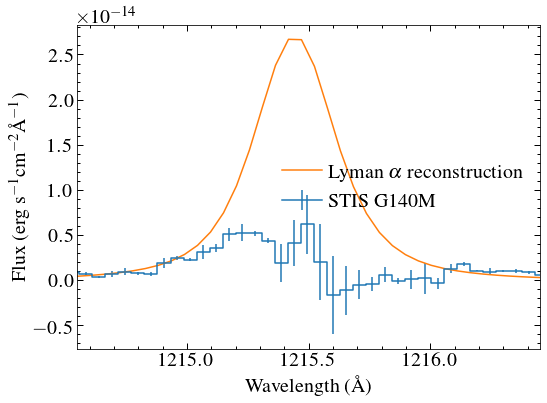

In [9]:
plt.figure(figsize=(8,6))
#plt.step(g140m['WAVELENGTH'], g140m['FLUX'], where = 'mid', label = 'STIS G140M')
plt.errorbar(g140m['WAVELENGTH'], g140m['FLUX'], yerr=g140m['ERROR'], drawstyle='steps-mid', label = 'STIS G140M')
#plt.errorbar(g140m1['WAVELENGTH'], g140m1['FLUX'], yerr=g140m1['ERROR'], drawstyle='steps-mid')

plt.plot(lya['WAVELENGTH'], lya['FLUX'], label= r'Lyman $\alpha$ reconstruction')
#plt.plot(wl1, fl1)
plt.xlim(1214.55, 1216.45)
plt.legend()

plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
plt.tight_layout()
#plt.savefig('../plots/T1_lya.pdf', dpi = 150)

Quick comparison with Swift measurement from https://arxiv.org/pdf/2005.01740.pdf

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


(1510, 2490)

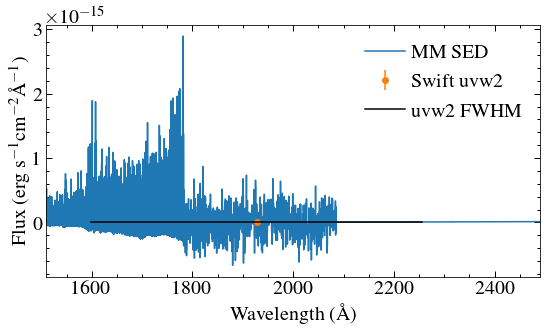

In [3]:
sf = 8e-15 #erg/cm2/s
sfe = 1.4e-15
scenw = 1928 
swb = 657

plt.figure(figsize = (8,5))
mask = (w > 1500) & (w < 2500) 
plt.step(w[mask], f[mask],label ='MM SED', where='mid')
plt.errorbar(scenw, sf/swb, yerr=sfe/swb, marker= 'o', ls='none', label= 'Swift uvw2')
plt.errorbar([scenw-(swb/2), scenw+(swb/2)], [1e-18, 1e-18], c='k', label='uvw2 FWHM')
plt.legend()
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
plt.tight_layout()
plt.xlim(1510, 2490)
#plt.yscale('log')

In [4]:
from scipy.stats import anderson

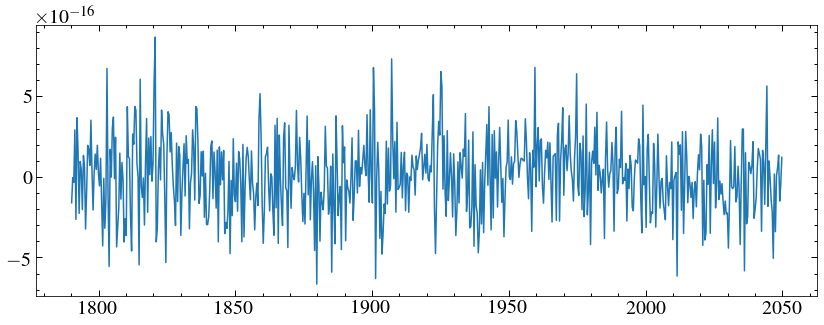

Mean = 6.808914853106819e-18
Std = 2.3336343330043994e-16


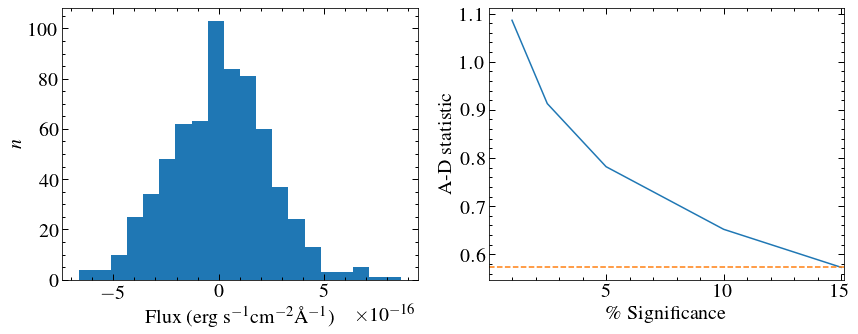

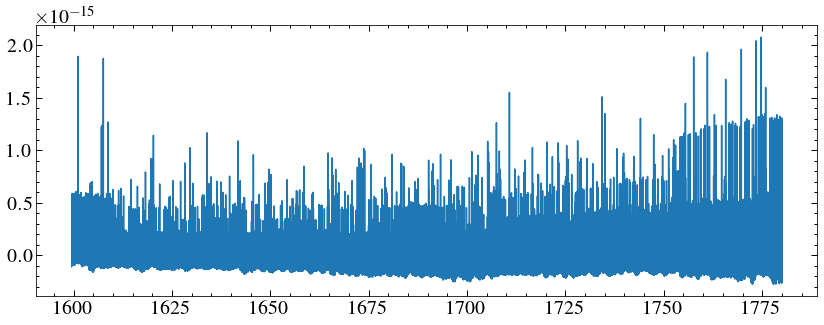

Mean = -2.1389901963385976e-17
Std = 2.525959819857171e-16


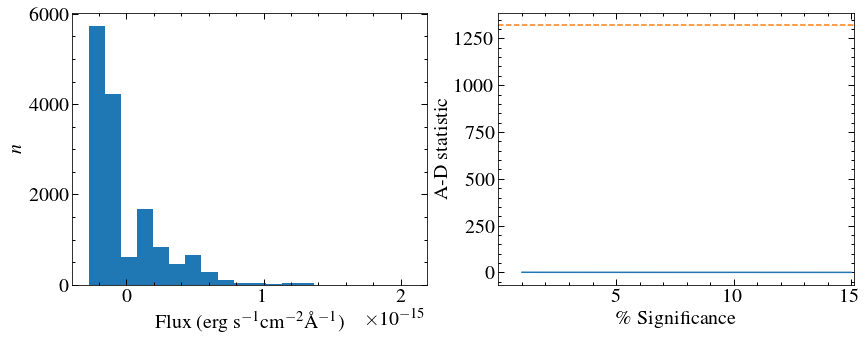

In [5]:

mask = (w >1790) & (w < 2050)
w1, f1 = w[mask], f[mask] 
plt.plot(w1, f1)
plt.show()
plt.subplot(121)
plt.hist(f1, bins = 20)
plt.xlabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
plt.ylabel('$n$')
#plt.annotate(r'Mean = {0:10.2f}, Std ={1:10.3f}'.format(np.mean(f1), np.std(f1)), (0.7, 0.9), xycoords='axes fraction')
print('Mean = {}'.format(np.mean(f1)))
print('Std = {}'.format(np.std(f1)))
plt.subplot(122)
ad = anderson(f1)
plt.plot(ad.significance_level, ad.critical_values)
plt.axhline(ad.statistic, ls='--', c= 'C1')
if ad.statistic > max(ad.critical_values):
    ad_result = ''
else:
    ad_result  = ' NOT'
#print('Light curve IS{0} variable'.format(ad_result))
plt.xlabel('\% Significance')
plt.ylabel('A-D statistic')
plt.xlim(0.001, 15.1)
plt.show()

mask = (w >scenw-(swb/2)) & (w < 1780)
w1, f1 = w[mask], f[mask] 
plt.plot(w1, f1)
plt.show()
plt.subplot(121)
plt.hist(f1, bins = 20)
plt.xlabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
plt.ylabel('$n$')
plt.subplot(122)
ad = anderson(f1)
plt.plot(ad.significance_level, ad.critical_values)
plt.axhline(ad.statistic, ls='--', c= 'C1')
if ad.statistic > max(ad.critical_values):
    ad_result = ''
else:
    ad_result  = ' NOT'
#print('Light curve IS{0} variable'.format(ad_result))
plt.xlabel('\% Significance')
plt.ylabel('A-D statistic')
print('Mean = {}'.format(np.mean(f1)))
print('Std = {}'.format(np.std(f1)))
plt.xlim(0.001, 15.1)
plt.show()

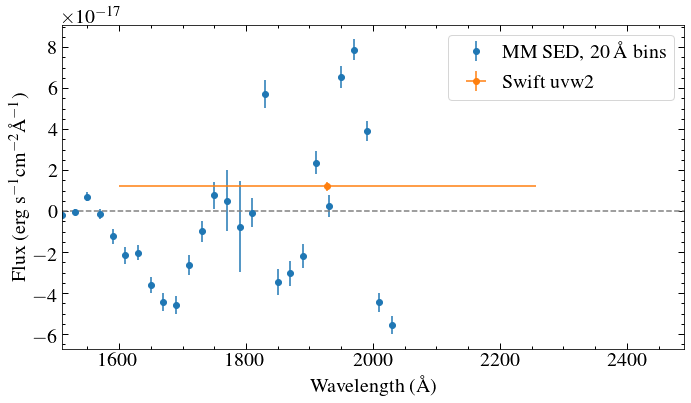

In [6]:
#mask = (w >1790) & (w < 2050)
#mask = (w >scenw-(swb/2)) & (w < 1780)
mask = (w > 1400) & (w < 2050) 
w1, f1, e1 = w[mask], f[mask], e[mask] 
#plt.plot(w1, f1)
#plt.plot(w1, e1)
w2 = np.arange(w1[0], w1[-1], 0.01)
f1 = interp1d(w1, f1, fill_value='extrapolate')(w2)
e1 = interp1d(w1, e1, fill_value='extrapolate')(w2)
w1=w2
binres = 20
binning= int((len(w1)*binres)/(w1[-1] - w1[0])) 
#print(binning)
#plt.show()
plt.figure(figsize = (10,6))


wave_binned = np.mean(w1[:(len(w1)//binning)*binning].reshape(-1,binning),axis=1)
flux_binned = np.mean(f1[:(len(f1)//binning)*binning].reshape(-1,binning),axis=1)
error_binned = np.sqrt(np.nansum((e1[:(len(f1)//binning)*binning].reshape(-1,binning))**2,axis=1))/binning
#print(wave_binned)
plt.errorbar(wave_binned, flux_binned, yerr= error_binned, marker='o', ls='none', label='MM SED, {}\,\AA\ bins'.format(binres))
plt.axhline(0, ls='--', c='0.5')



plt.errorbar(scenw, sf/swb, yerr=sfe/swb,xerr=swb/2, marker= 'o', ls='none', label= 'Swift uvw2')
#plt.errorbar([scenw-(swb/2), scenw+(swb/2)], [8e-17, 8e-17], c='k', label='uvw2 FWHM')
#plt.legend()
plt.legend(loc=1, frameon=True)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Flux (erg s$^{-1}$cm$^{-2}$\AA$^{-1}$)')
plt.xlim(1510, 2490)

#plt.step(w1, f1, alpha=0.5, c='C0', zorder=-10)
#plt.ylim(-1e-16,1e-16)
#plt.yscale('log')
plt.tight_layout()


In [84]:
print(len(w1))
print(w1[-1] - w1[0])

665
259.66843192732654


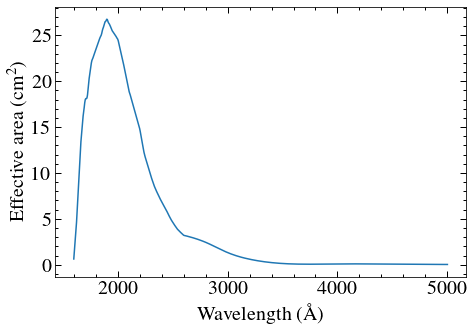

In [7]:
plt.figure(figsize=(7, 5))
bpw, bpf = np.loadtxt('/home/david/work/filters/uvot/Swift_UVOT.UVW2.dat', unpack=True)
plt.plot(bpw, bpf)
plt.xlabel('Wavelength (\AA)')
plt.ylabel('Effective area (cm$^2$)')
plt.tight_layout()

In [9]:
def make_phot(bp_w, bp_cc, w, f):
    bb_cci = interp1d(bp_w, bp_cc, fill_value='extrapolate')(w)
    return np.trapz(f*bb_cci, w)/np.trapz(bb_cci, w)

In [12]:
mask = (w >= bpw[0]) & (w <= bpw[-1]) 
w1, f1, e1 = w[mask], f[mask], e[mask]
phot = make_phot(bpw, bpf, w1, f1)
print(phot*(bpw[-1]-bpw[0]))

1.871470180795556e-14


Thinking about WFC observations - make Mg ii emission line spectrum and put into etc

In [7]:
f280n = Table.read('../../../../filters/wfc3/UVIS/F280N_UVIS_throughput.csv')


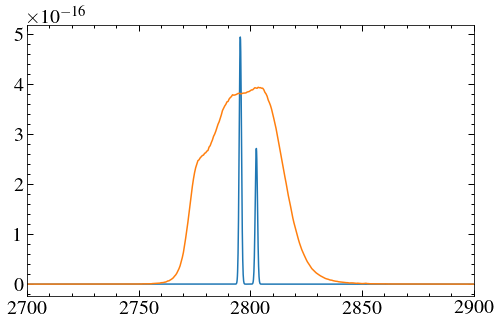

In [26]:
plt.figure(figsize=(8,5))
 
#plt.plot(f280n['Chip 2 Wave (Angstroms)'], f280n['Chip 2 Throughput']) #about a 1% difference

#plt.axhline(1)
mg_flux = [620e-18, 340e-18]
mglines = [2795.523, 2802.697]
std = 0.5
mgamp = np.array([A/(std*(2*np.pi)**0.5) for A in mg_flux])
modw = np.arange(2700, 2900, 0.1)
mgmod = models.Gaussian1D(mgamp[0], mglines[0], std) + models.Gaussian1D(mgamp[1], mglines[1], std)
modf = mgmod(modw)
plt.plot(modw, modf)
scale = np.mean(modf)/np.mean(f280n['Chip 1 Throughput'])
plt.plot(f280n['Chip 1 Wave (Angstroms)'], f280n['Chip 1 Throughput']*scale)
plt.xlim(2700, 2900)
savdat = Table([modw, modf])
ascii.write(savdat, 'mgii model.txt', overwrite=True, format='basic')

[6.2e-16, 3.4e-16]